## Import packages

In [1]:
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import brevitas.nn as qnn

## Paths to dataset files, output weights and and important constants

In [2]:
project_path = Path.cwd().parent
data_path = project_path / 'data' / 'arc' / 'SpO2'

input_path = data_path / 'SpO2_input_cleaned4%.csv'
output_path = data_path / 'SpO2_output_cleaned4%.csv'

assert input_path.exists(), "file does not exist"
assert output_path.exists(), "file does not exist"


In [3]:
WEIGHT_BIT_WIDTH = 4  # try 2, 3, 4 bits
INPUT_BIT_WIDTH = 5  # originally, SpO2 data are 5 bits ([0-31])
save_weight_path = project_path/f"weights/SpO2/qat/quant_fc_{INPUT_BIT_WIDTH}bits_data_{WEIGHT_BIT_WIDTH}bits_weights.pth"
print(f"weight path = {save_weight_path}")

weight path = /Users/khoaguin/Desktop/projects/NISEC/Privacy-Preserving-ML-through-HHE/weights/SpO2/qat/quant_fc_5bits_data_4bits_weights.pth


## Dataset

In [4]:
split_ratio = (0.6, 0.2, 0.2)

class SpO2(Dataset):
    split: str

    def __init__(self, input_path: Path, output_path: Path, 
                quantize: bool = False, split: str = 'train'):
        self.split = split
        x = np.loadtxt(input_path, dtype=int, delimiter=',')
        y = np.loadtxt(output_path, dtype=int, delimiter=',')
        assert len(x) == len(y), "input and output have different number of examples"
        
        if quantize:
            x = (x - np.min(x)) / (np.max(x) - np.min(x))
            x = (x * (2**INPUT_BIT_WIDTH - 1)).astype(int)
            # x = x.float() / 4

        train_split_index = int(x.shape[0] * split_ratio[0])
        val_split_index = int(x.shape[0] * (split_ratio[0] + split_ratio[1]))
        if split == 'train':
            self.x = x[:train_split_index, :]
            self.y = y[:train_split_index]
        elif split == 'eval':
            self.x = x[train_split_index:val_split_index, :]
            self.y = y[train_split_index:val_split_index]
        elif split == 'test':
            self.x = x[val_split_index:, :]
            self.y = y[val_split_index:]
        else:
            raise ValueError(f"no option for 'split = {split}'")
        
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        self.y = torch.unsqueeze(self.y, dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def print_info(self):
        print(f"----------- {self.split} dataset info -----------")
        print(f"{self.x.shape = }")
        print(f"{self.y.shape = }")
        print(f"input unique values = {self.x.unique()}")
        print(f"maximum input value = {torch.max(self.x).item()}")
        print(f"minimum input value = {torch.min(self.x).item()}")

In [5]:
train_dataset = SpO2(input_path=input_path, 
                    output_path=output_path, 
                    split='train', quantize=False)
val_dataset = SpO2(input_path=input_path, 
                output_path=output_path, 
                split='eval', quantize=False)
test_dataset = SpO2(input_path=input_path, 
                    output_path=output_path, 
                    split='test', quantize=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
train_dataset.print_info()
val_dataset.print_info()
test_dataset.print_info()

----------- train dataset info -----------
self.x.shape = torch.Size([14950, 300])
self.y.shape = torch.Size([14950, 1])
input unique values = tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.])
maximum input value = 30.0
minimum input value = 1.0
----------- eval dataset info -----------
self.x.shape = torch.Size([4984, 300])
self.y.shape = torch.Size([4984, 1])
input unique values = tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.])
maximum input value = 30.0
minimum input value = 1.0
----------- test dataset info -----------
self.x.shape = torch.Size([4984, 300])
self.y.shape = torch.Size([4984, 1])
input unique values = tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 

class = 0.0


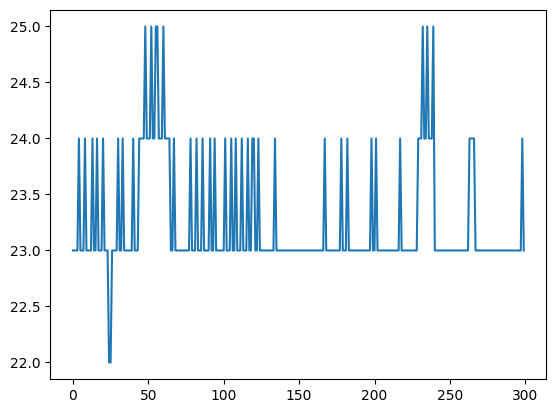

In [7]:
example_input = train_dataset[4][0]
example_output = train_dataset[4][1]
print(f'class = {example_output.item()}')
plt.plot(example_input)

In [8]:
for x, y in test_loader:
    print(x.shape, y.shape)
    print(x.unique())
    # print((x.dtype))
    break

torch.Size([64, 300]) torch.Size([64, 1])
tensor([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
        30.])


## Model

In [9]:
def accuracy(outputs, labels):
    preds = outputs.round()
    assert len(preds) == len(labels)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class BaseModel(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        inp, labels = batch
        out = self(inp)  # Generate predictions
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.binary_cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))


class SpO2OneFCQuantModel(BaseModel):
    """
    1 linear layer
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=300, out_features=1, bias=False, 
                                weight_bit_width=WEIGHT_BIT_WIDTH)
        self.sigmoid = nn.Sigmoid()

    def forward(self, xb):
        out = self.fc1(xb)
        out = self.sigmoid(out)

        return out

model = SpO2OneFCQuantModel()
model

SpO2OneFCQuantModel(
  (fc1): QuantLinear(
    in_features=300, out_features=1, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
          (input_view_impl): Identity()
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameter(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
    

## Train and evaluate

In [10]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, 
        train_loader, val_loader, test_loader, 
        file_path, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    high_acc = 0.8
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        if epoch >= 2:
            eval_dict = evaluate(model, test_loader)
            print(str(epoch) + "\t" + str(eval_dict))
            if eval_dict['val_acc'] > high_acc:
                high_acc = eval_dict['val_acc']
                torch.save(model.state_dict(), file_path)
                print(f"Saved into {file_path.relative_to(project_path)}")

    return history

In [11]:
history = [evaluate(model, val_loader)]
history += fit(epochs=150, lr=0.001, model=model, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            test_loader=test_loader, 
            file_path=save_weight_path, 
            opt_func=torch.optim.Adam)

Epoch [1], val_loss: 0.5606, val_acc: 0.7855


/Users/khoaguin/Desktop/projects/NISEC/Privacy-Preserving-ML-through-HHE/.venv/lib/python3.11/site-packages/torch/_tensor.py:1645: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/c10/core/TensorImpl.h:1942.)
  return super().rename(names)


Epoch [2], val_loss: 0.5243, val_acc: 0.7935
Epoch [3], val_loss: 0.5162, val_acc: 0.7879
2	{'val_loss': 0.5126604437828064, 'val_acc': 0.7922676205635071}
Epoch [4], val_loss: 0.5221, val_acc: 0.8039
3	{'val_loss': 0.5207949280738831, 'val_acc': 0.801682710647583}
Saved into weights/SpO2/qat/quant_fc_5bits_data_4bits_weights.pth
Epoch [5], val_loss: 0.5085, val_acc: 0.7897
4	{'val_loss': 0.5061982870101929, 'val_acc': 0.7942708134651184}
Epoch [6], val_loss: 0.5135, val_acc: 0.7903
5	{'val_loss': 0.5109215974807739, 'val_acc': 0.7942708134651184}
Epoch [7], val_loss: 0.4970, val_acc: 0.7933
6	{'val_loss': 0.4959481954574585, 'val_acc': 0.7982772588729858}
Epoch [8], val_loss: 0.5797, val_acc: 0.7851
7	{'val_loss': 0.5754066109657288, 'val_acc': 0.7896634340286255}
Epoch [9], val_loss: 0.4915, val_acc: 0.7985
8	{'val_loss': 0.49172112345695496, 'val_acc': 0.8018830418586731}
Saved into weights/SpO2/qat/quant_fc_5bits_data_4bits_weights.pth
Epoch [10], val_loss: 0.4975, val_acc: 0.8090


## Inference on Test Dataset

In [12]:
model = SpO2OneFCQuantModel()
print(f"loading saved weights from {save_weight_path.relative_to(project_path)}")
model.load_state_dict(
    torch.load(save_weight_path,
    map_location=torch.device('cpu'))
)

loading saved weights from weights/SpO2/qat/quant_fc_5bits_data_4bits_weights.pth


<All keys matched successfully>

### Automatic inference with Brevitas

In [13]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {WEIGHT_BIT_WIDTH}-bit weights = {acc}")

test accuracy with trained 4-bit weights = 0.8235176205635071


### Manual Inference

1FC

In [14]:
model = SpO2OneFCQuantModel()
model.load_state_dict(
    torch.load(save_weight_path,
    map_location=torch.device('cpu'))
)

total_acc = 0
max_value = -9999
min_value = 9999

# Get quantized weights and scale them properly
fc1 = model.fc1.quant_weight().value.detach()
print(f"{fc1.shape = }")
print(f"{fc1.unique() = }")

# Scale weights to integer range for the bit width
max_int = 2**(WEIGHT_BIT_WIDTH-1) - 1
max_weight = fc1.abs().max()
scale_factor = max_int / max_weight if max_weight > 0 else 1

# Scale both weights and inputs to integer domain
fc1_scaled = torch.round(fc1 * scale_factor).to(torch.int32)
fc1_scaled = torch.transpose(fc1_scaled, 0, 1)

print(f"Scaled fc1 unique values: {fc1_scaled.unique()}")

sigmoid = nn.Sigmoid()

for inp, label in test_loader:
    # Scale input to match weight scaling
    inp_scaled = torch.round(inp).to(torch.int32)
    out = torch.matmul(inp_scaled, fc1_scaled)
    
    if torch.max(out) > max_value:
        max_value = torch.max(out)
    if torch.min(out) < min_value:
        min_value = torch.min(out)

    # Convert back to float for sigmoid
    out = out.to(torch.float32) / scale_factor
    out = sigmoid(out)
    pred = out.round()
    acc = (pred == label)
    total_acc += acc.sum()

print(f"Manual Inference: Got {total_acc / len(test_dataset) * 100:.2f}% accuracy")
print(f"{max_value = }")
print(f"{min_value = }")

fc1.shape = torch.Size([1, 300])
fc1.unique() = tensor([-0.0409, -0.0350, -0.0292, -0.0234, -0.0175, -0.0117, -0.0058,  0.0000,
         0.0058,  0.0117,  0.0175,  0.0234,  0.0292,  0.0350,  0.0409])
Scaled fc1 unique values: tensor([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7],
       dtype=torch.int32)
Manual Inference: Got 82.30% accuracy
max_value = tensor(1748, dtype=torch.int32)
min_value = tensor(-1017, dtype=torch.int32)


### Export integer weights to csv file

In [15]:
fc1_float = model.fc1.quant_weight().value.detach()

# Scale to integer range for n-bit quantization
max_int = 2**(WEIGHT_BIT_WIDTH-1) - 1
max_weight = fc1_float.abs().max()

if max_weight > 0:
    scale = max_int / max_weight
    fc1_int = torch.round(fc1_float * scale).to(torch.int16)
else:
    fc1_int = torch.zeros_like(fc1_float, dtype=torch.int16)

fc1_transposed = torch.transpose(fc1_int, 0, 1)
fc1_df = pd.DataFrame(fc1_transposed.numpy())

# This will save properly scaled integer weights
csv_path = project_path/f"weights/SpO2/qat/quant_fc_{INPUT_BIT_WIDTH}bits_data_{WEIGHT_BIT_WIDTH}bits_weights.csv"
fc1_df.to_csv(csv_path, index=False, header=False)
print(f"Saved properly scaled weights with range [-{max_int}, {max_int}] to: {csv_path.name}")

Saved properly scaled weights with range [-7, 7] to: quant_fc_5bits_data_4bits_weights.csv
